In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
#from wordcloud import STOPWORDS

from re import sub
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [6]:
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Error loading wordnet: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>
[nltk_data] Error loading omw-1.4: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>


False

In [2]:
sites = pd.read_csv("downloaded-files\whc-en-2024-01-05.csv")

Almost 70% of entries in the justification column are null and are hence avoided for now

In [20]:
sites['justification_en'].isna().sum() / len(sites['justification_en'])

0.7227564102564102

# Text-Normalisation

In [3]:
def text_normaliser(lemmatizer=WordNetLemmatizer()):
   def normaliser(document):
      # Normalise? Or do later...
      document = document.lower()
      tokens = [token for token in word_tokenize(document) if token not in ENGLISH_STOP_WORDS.union(string.punctuation)]
      document = ' '.join([lemmatizer.lemmatize(word) for word in tokens])
      return document
   
   return normaliser

In [4]:
# Remove HTML tags
sites['short_description'] = sites['short_description'].map(lambda x: sub('<[^<]+?>', '', x))

# Normalise: lower case, remove stop words and punctuation, rejoin to sentences
wnl = WordNetLemmatizer()
sites['short_description'] = sites['short_description'].map(text_normaliser(wnl))

# WordClouds

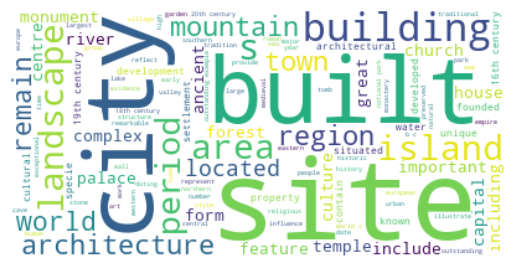

In [14]:
descriptions = " ".join(desc for desc in sites["short_description"]).lower()

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color = "white", stopwords=ENGLISH_STOP_WORDS).generate(descriptions)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Vectorizers

In [56]:
def vectorize(data, vectorizer=CountVectorizer(max_features=100)):
    vect = vectorizer.fit(data)
    X = vect.transform(data)
    return pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())

In [22]:
def highest_correlation(data, vectorizer=CountVectorizer(max_features=100)):
    vect = vectorizer.fit(data)
    X = vect.transform(data)
    count_vect_desc = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
    
    c = count_vect_desc.corr()#.abs()
    triu_c = c.where(np.triu(np.ones(c.shape), k=1).astype(bool))

    s = triu_c.unstack()
    so = s.sort_values(kind="quicksort")
    
    so.index.names = ["A", "B"]
    no_repeat_so = so.loc[so.index.get_level_values("A") != so.index.get_level_values("B")]
    
    return no_repeat_so.sort_values(key=abs, ascending=False)

In [25]:
correlations = highest_correlation(sites['short_description'], CountVectorizer(max_features=100, stop_words=list(ENGLISH_STOP_WORDS)))

In [51]:
correlations = correlations[correlations.notna()]
correlations = correlations[correlations.abs() > 0.1]

A            B             
outstanding  example           0.367813
century      19th              0.362514
site         archaeological    0.346691
specie       including         0.339815
             forest            0.339613
                                 ...   
development  archaeological    0.100414
river        central           0.100385
water        property          0.100121
natural      largest           0.100113
human        built            -0.100059
Length: 411, dtype: float64

In [59]:
# Logistic Regression?
conclusive_sites = sites.loc[sites['category'].isin(['Natural', 'Cultural'])]
X = vectorize(conclusive_sites['short_description'])
y = conclusive_sites['category']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regressor = LogisticRegression().fit(X_train, y_train)

In [62]:
print('Accuracy on training data: ', regressor.score(X_train, y_train))
print('Accuracy on testing data: ', regressor.score(X_test, y_test))

Accuracy on training data:  0.9870689655172413
Accuracy on testing data:  0.9655172413793104


In [63]:
y_predicted = regressor.predict(X_test)
print(confusion_matrix(y_test, y_predicted)/len(y_test))

[[0.78017241 0.01724138]
 [0.01724138 0.18534483]]


In [75]:
coefficients = pd.Series(data=regressor.coef_[0], index=X_test.columns)

AttributeError: 'Series' object has no attribute 'columns'

<Axes: >

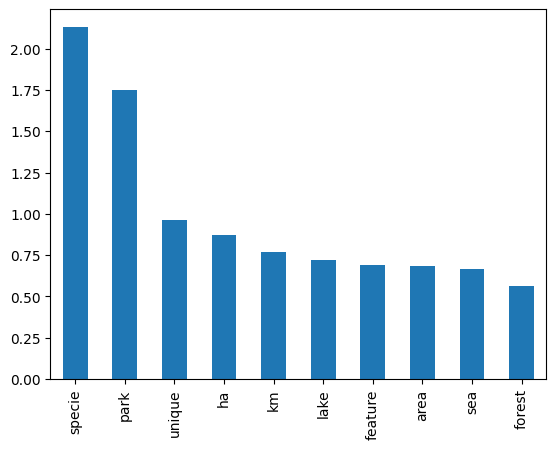

In [78]:
coefficients.sort_values(ascending=False)[0:10].plot.bar()

<Axes: >

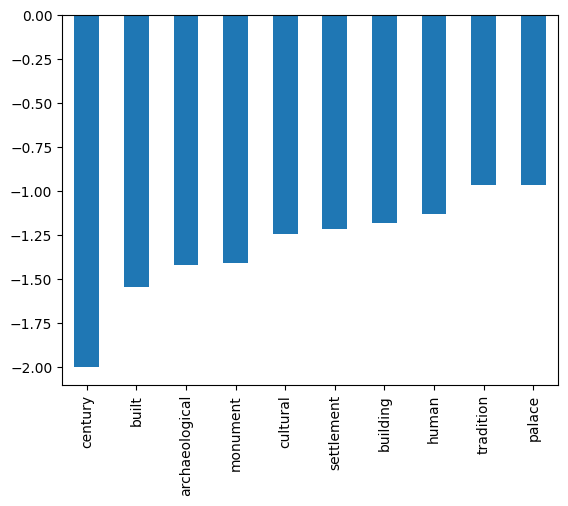

In [79]:
coefficients.sort_values()[0:10].plot.bar()